# Chapter 3. Classification

## 0. Import Libraries & Helper Functions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## MNIST Dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, parser='auto')

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

print(f"X Shape: {X.shape}, y Shape: {y.shape}")

X Shape: (70000, 784), y Shape: (70000,)


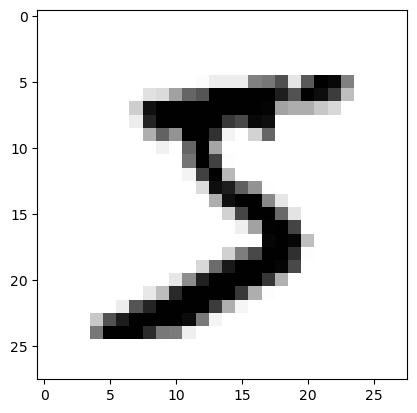

In [5]:
some_digit = X[0:1]
some_digit_image=some_digit.values.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')

In [6]:
print(f"Label: {y[0]}")
y = y.astype(np.uint8)

y[0]

Label: 5


5

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], X[:60000]

## Binary Classifier

Let's simplify the problem and only try to identify whether the input is the number 5, which we call a "5_detector".

In [49]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

In [50]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [51]:
sgd_clf.predict(some_digit)

array([ True])

## Performance Measures

### Confusion Matrix

A great way to evaluate the performance of a classifier is via a confusion matrix.

The general idea is to evalute the the number of times class A was was labled as class B, and vice versa (e.g how many times was a 3 labeled as a 5).

To compute a confusion matrix, you first need to have a set of actual predictions that can be compared to the actual targets. You could use the test set, but we only want to use the test set at the end of a project when we have a trained model we are ready to lanuch).

Instead we can use cross val predict on the training data. 

In [52]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
folds = 3

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=folds)

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual calss, while each column presents a predicted class.

The first row considers the negative class (e.g 53,892 were correctly classified as non-5's & 687 were incorrectly classified as 5's).

The second row considers the positive class (e.g 1,891 were incorrectly classified as non-5's & 3,530 were correctly classified as 5's).

A perfect classifier would have only have true positives and true negatives

### Precision & Recall

In [53]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision Score: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall Score: {recall_score(y_train_5, y_train_pred)}")

Precision Score: 0.8370879772350012
Recall Score: 0.6511713705958311


It is often convenient to combine precision & recall into a single metric called the `F1 Score`, which is the harmonic mean between precision and recall. This is especially helpful if you need to compare multiple classifiers.

In [54]:
from sklearn.metrics import f1_score

print(f"F1 Score: {f1_score(y_train_5, y_train_pred)}")

F1 Score: 0.7325171197343846


The `F1 Score` tends to favor classifiers that have similar precision & recall, but that is not always what you want. In some cases, you might care more about precision, and in others recall.

For example, if you cared about classifying videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only the safe ones (high precision)

On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine to have low precision as long as it has high recall.

Unfortunately, you can't have it both ways: increasing precision reduces recall and vice versa, which is the precision/recall trade off.

### Precision / Recall Tradeoff

In [55]:
y_scores = sgd_clf.decision_function(some_digit)
print(f"y_scores: {y_scores}")
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

y_scores: [2164.22030239]


array([ True])

The SGDClassifier uses a threshold of 0, so the previous code returns the same result as the predict method. 

Let's now raise the threshold:

In [56]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases the recall - the images actually represents a 5, and the classifier detects it when the threshold is 0 but misses it when the threshold is 8000.

How do you decide which threshold to use? Use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return the decision scores instead of predictions:

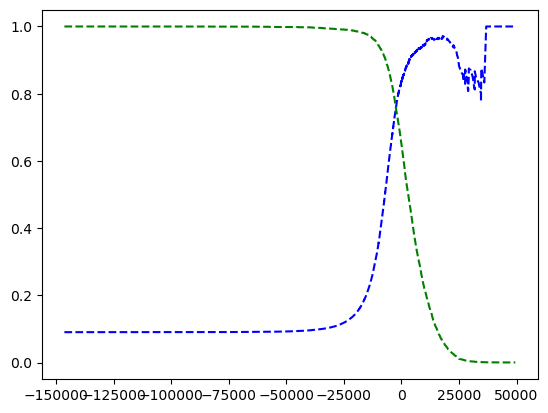

In [57]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thesholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g--', label="Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Suppose you decide to aim for 90% precision, and the target is 8000. You can use `np.argmax()` to find the lowest threshold that gives you at least 90% precision. However, a high precision classifier is not helpful if it has low recall!

In [60]:
theshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
theshold_90_precision

3370.0194991439566

In [61]:
y_train_pred_90 = (y_scores >= theshold_90_precision)

print(f"{precision_score(y_train_5, y_train_pred_90)}")
print(f"{recall_score(y_train_5, y_train_pred_90)}")

0.9000345901072293
0.4799852425751706


### The ROC Curve

The receiver operating characteristic (ROC) curve is another tool used w/ binary classifiers. it plots the true positive rate (e.g recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive, and is equal to 1 - true negative rate (TNR or specificity), which is the ratio of negative instasnces that are correctly classified as negative.

Hence, the ROC curve plots recall against specificity.

As a rule of thumb, use the PR curve whenever the positive class is rare or when you care more about false positives than false negatives. Otherwise, use the ROC curve.

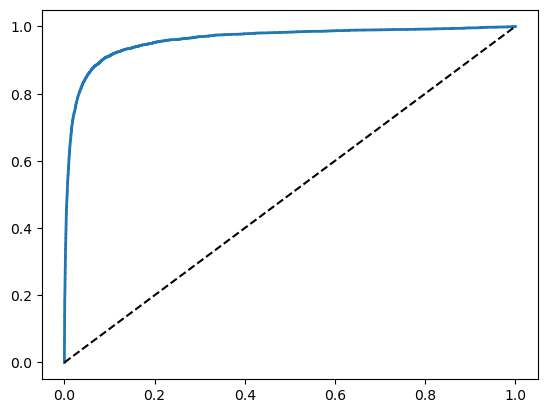

In [62]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, lable=None):
    plt.plot(fpr, tpr, linewidth=2, label=lable)
    plt.plot([0,1], [0,1], 'k--')
    
plot_roc_curve(fpr,tpr)

One way to compare classifiers is to measure `area under the curve` e.g AUC. A perfect classifier will have a AUC = 1, and a purely random classifier will have a AUC of 0.5

In [63]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's not use a `RandomForestClassifer` and compare:

In [64]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = prob of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

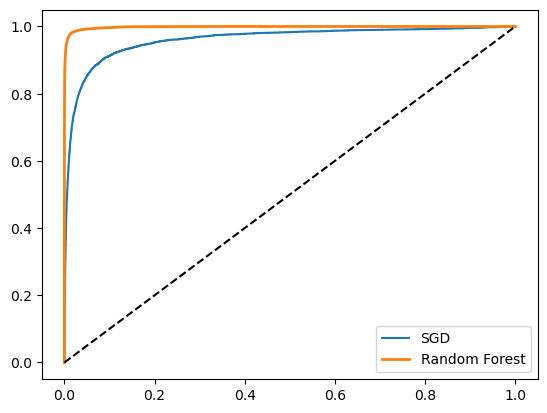

In [65]:
plt.plot(fpr, tpr, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [66]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Multiclass Classification

Some classifiers (e.g SGD, Random Forest, Naive Bayes) are capable of handling multiple classes natively, while others Logistic Regression, SVM's) are strictly binary. However, there are stratigies you can use to perform multiclassification with binary classifiers.

One way is via a `One-Versus-The-Rest` (e.g OVR) strategy - you train a classifier for each class, and then you get a decision score for each classifier for a given input. The classifier with the highest score wins. 

Another is via a `One-Versus-One`, you train a classifier for pair of potential outputs (e.g 0 vs 1, 0 vs 2, 0 vs 3, ect) and then you run an input through every classifier and see which class wins the most duels. The main advantage here is that each classifier only needs to be trained on the part of the training set for the two classes it must distinguish.

Some algo's scale poorly with the size of the training set, meaning `OVO` would be preferred since it is faster train many calssifiers on small training sets than to train a few classifiers on large training sets. For most binary classificaiotn algorithms, `OVR` is preferred. 

#### OVO Strategy (SVC is natively an OVO)

In [67]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict(some_digit)

array([5], dtype=uint8)

In [68]:
some_digit_scores = svm_clf.decision_function(some_digit)
print(some_digit_scores)

print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[0 1 2 3 4 5 6 7 8 9]
5


#### OVR Strategy

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict(some_digit)
len(ovr_clf.estimators_)

In [ ]:
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict(some_digit))
print(f"Scores: {sgd_clf.decision_function(some_digit)}")

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

### Error Analysis

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

NameError: name 'X_train_scaled' is not defined

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

To compare error rates...

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdism=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonalagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

Looking at the plot can help uncover where you should focus your efforts. For instance in this dataset, our efforts should be focusing on reducing the false 8's, 

### Multilabel Classification

Until now, each instance has always been assigned to just one class. But consider a face-recognition classifier - it should assign one tag for each face in a picture that it recognizes, and thus, we would expect the output to be something along the lines of [0,1,0]. Such a classifier is called a multilable classification system.

Here is a simple example, where we create two target labels for each image - first whether the input is large (e.g 7, 8, 9) and second whether is an odd number. We train the classifier using a multiple labels array.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

knn.predict(some_digit.values)

/Users/zacharymessinger/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

It gets it right! The digit 5 is indeed not large (False) and it is odd (True).

There are many ways to evaluate a mutlilabel classifier & selecting the right metric depends on the project. One way is to us the F1 score for each individual label and then compute the average score. But that asummes all labels are equally important.

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn, X_train.values, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

If certain labels hold more weight than others, you can assign weights to each label relative to it's support

### Multioutput Classification

Multioutpout classification is where each label can be multiclass (e.g it can have more than two possible values).

As an example, let's build a system that removes the noise from inamges by taking in a noisy digit image and outputting a clean image represented as an array of pixels. Notice that the output is a multilabel and each label can have mulitple values (pixel intensity ranges from 0 to 255).

In [20]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [31]:
knn.fit(X_train_mod, y_train_mod)
some_digit_mod=X_train_mod
clean_digit = knn.predict(some_digit_mod)
plt.imshow(clean_digit,cmap='binary')

AttributeError: 'Flags' object has no attribute 'c_contiguous'